## This notebook learns node embeddings by DeepWalk and Node2Vec

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import pandas as pd
import numpy as np 
import gensim

import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from node2vec import Node2Vec
from tqdm import tqdm
import random

In [1]:
!pip install --upgrade gensim
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 51 kB 199 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=232b06027034087bc172197c6936a6f83fb07840ae7353f37509d564ed110a92
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df=pd.read_csv('criteo-uplift-v2.1.csv')
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [ ]:
col=df.columns
y=torch.from_numpy((np.array(df['conversion']))).reshape(df.shape[0],1).to(torch.float32)
x=torch.from_numpy(np.array(df[[c for c in df.columns[:-4]]+["visit"]+["treatment"]])).to(torch.float32)
x=x[0].reshape(-1,1)
y=y[0].reshape(-1,1)

# load edge index
edge_index=pd.read_csv('edge_index_criteo.csv')
edge_index=torch.from_numpy(np.transpose(np.array(edge_index)))

data=Data(x=x,edge_index=edge_index,y=y)

In [ ]:
random_walks = []
def get_randomwalk(node, path_length):
    
    random_walk = [node] 
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk
    
G=to_networkx(data)
all_nodes=list(G.nodes())

for n in tqdm(all_nodes):
    for i in range(20):
        random_walks.append(get_randomwalk(n,50))

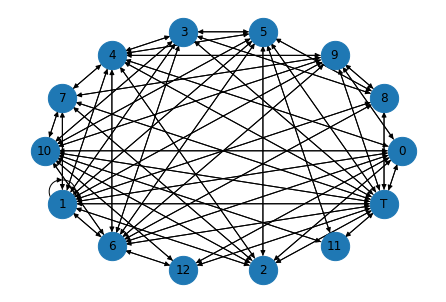

In [ ]:
def draw(Data):
    G = to_networkx(Data)
    mapping = {13:'T' }
    relabeled_G = nx.relabel_nodes(G,mapping)
    nx.draw_circular(relabeled_G,node_size=800,with_labels=True)
    plt.savefig("path.png")
    plt.show()
draw(data)

## Node embeddings generated from deepwalk

In [ ]:
model = Word2Vec(vector_size=10,window = 4, sg = 1, hs = 0,
                 negative = 3, alpha=0.03, min_alpha=0.0007,seed = 14)
model.build_vocab(random_walks, progress_per=5)
model.train(random_walks,total_examples = model.corpus_count, epochs=30, report_delay=1)
model.save(r"deepwalk_10d_x13.model")
files.download("deepwalk_10d_x13.model")
model.wv.similar_by_word(1)

[(9, 0.9577751755714417),
 (12, 0.9298327565193176),
 (5, 0.9186494946479797),
 (3, 0.9053271412849426),
 (2, 0.892383873462677),
 (11, 0.8884193897247314),
 (7, 0.8615646958351135),
 (0, 0.8539919257164001),
 (13, 0.8308837413787842),
 (8, 0.8088979125022888)]

## Node embeddings generated from Node2Vec

In [ ]:
node2vec = Node2Vec(graph=G, dimensions=10, walk_length=50, num_walks=100, workers=4)  # Use temp_folder for big graphs
model = node2vec.fit(window=4, min_count=1, batch_words=4)  
model.save(r"Node2Vec_10d_x13.model")
files.download("Node2Vec_10d_x13.model")
model.wv.similar_by_word(1)

Computing transition probabilities:   0%|          | 0/14 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 25/25 [00:00<00:00, 394.17it/s]


[('4', 0.9629924893379211),
 ('8', 0.9616152048110962),
 ('2', 0.9490526914596558),
 ('9', 0.9373694658279419),
 ('13', 0.925393283367157),
 ('3', 0.9115868210792542),
 ('0', 0.9084211587905884),
 ('5', 0.9048509001731873),
 ('7', 0.9010432958602905),
 ('6', 0.8865363001823425)]